In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(1)

In [3]:
""" Implement the following function, which pads all the images of a batch of examples X with zeros. Use np.pad. Note if you want to pad the array "a" of shape  (5,5,5,5,5)
  with pad = 1 for the 2nd dimension, pad = 3 for the 4th dimension and pad = 0 for the rest, you would do:
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
"""


#Zero_Pad
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.

    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions

    Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C). Typical example: m = batch size, n_C = 3 (RGB)
    """
    X_pad = np.pad(
        X,
        pad_width=((0, 0),          # no padding on examples dimension (m)
                   (pad, pad),      # pad top and bottom (height)
                   (pad, pad),      # pad left and right (width)
                   (0, 0)),         # no padding on channels dimension (n_C)
        mode='constant',            # pad with constant value (default = 0)
        constant_values=0
    )

    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[-0.34385368  0.04359686]
 [-0.62000084  0.69803203]
 [-0.44712856  1.2245077 ]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


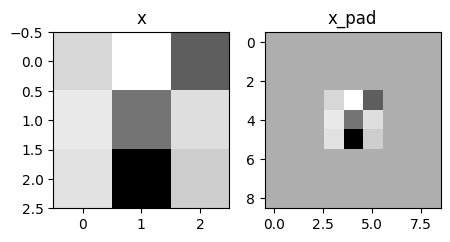

In [4]:
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])

## Single Step of Convolution

In [5]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation
    of the previous layer.

    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = a_slice_prev * W
    
    # Sum over all entries of the volume s
    Z = np.sum(s)
    
    # Add bias to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)

    return Z

In [7]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)



Z = -6.999089450680221


/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_57070/3264920998.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume:
<center>
<video width="620" height="440" src="convolution_illus.mp4" type="video/mp4" controls>
</video>
</center>

In [9]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function

    Arguments:
    A_prev -- output activations of the previous layer,
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"

    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """

    # Retrieve dimensions from A_prev's shape (≈1 line)
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev + 2 * pad - f) / stride + 1)
    n_W = int((n_W_prev + 2 * pad - f) / stride + 1)
    
    # Initialize the output volume Z with zeros.
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    # loop over the batch of training examples
    for i in range(m):
        # Select ith training example's padded activation
        a_prev_pad = A_prev_pad[i]          # shape: (n_H_prev + 2*pad, n_W_prev + 2*pad, n_C_prev)
        
        # loop over vertical axis of the output volume
        for h in range(n_H):
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h * stride
            vert_end   = vert_start + f
            
            # loop over horizontal axis of the output volume
            for w in range(n_W):
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                horiz_start = w * stride
                horiz_end   = horiz_start + f
                
                # loop over channels (= #filters) of the output volume
                for c in range(n_C):
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    weights = W[:, :, :, c]          # shape (f, f, n_C_prev)
                    biases  = b[:, :, :, c]          # shape (1,1,1) or just scalar after squeezing
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)


    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [10]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
cache_0_1_2_3 = cache_conv[0][1][2][3]
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)
print("cache_conv[0][1][2][3] =\n", cache_0_1_2_3)


Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_57070/3264920998.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


## Pooling Layer

In [12]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer

    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")

    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters
    """

    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))

    for i in range(m):
        # loop on the vertical axis of the output volume
        for h in range(n_H):
            # loop on the horizontal axis of the output volume
            for w in range(n_W):
                # loop over the channels of the output volume
                for c in range(n_C):
                    # Find the corners of the current "slice"
                    vert_start  = h * stride
                    vert_end    = vert_start + f
                    horiz_start = w * stride
                    horiz_end   = horiz_start + f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c.
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice.
                    # Use an if statement to differentiate the modes.
                    # Use np.max / np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)

    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)

    # Making sure your output shape is correct
    #assert(A.shape == (m, n_H, n_W, n_C))

    return A, cache

In [13]:
# Test Case 1: stride of 1
print("CASE 1:\n")
np.random.seed(1)
A_prev_case_1 = np.random.randn(2, 5, 5, 3)
hparameters_case_1 = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])


CASE 1:

mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]
mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]


In [14]:
# Test Case 2: stride of 2
print("\n\033[0mCASE 2:\n")
np.random.seed(1)
A_prev_case_2 = np.random.randn(2, 5, 5, 3)
hparameters_case_2 = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])


CASE 2:

mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


## Backpropagation in CNNs